# Tuolumne Boxplots

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [9]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [10]:
mpl_epoch = '1970-01-01'

## Create File Paths to Snow On ASO Data for Rasterstats Calculations

In [30]:
from rasterstats import zonal_stats

In [38]:
aso_fn_winters = ['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200413_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
                  '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif']

In [39]:
# written by Hannah Besso, June 30, 2022

def build_stats(rasterstats):
    rasterstats = rasterstats[0]
    stats_dict = {'mean':rasterstats['mean'], 'iqr':(rasterstats['max']-rasterstats['min']), 'whishi':rasterstats['max'], 'whislo':rasterstats['min'], 'q1':rasterstats['percentile_25'], 'med':rasterstats['median'], 'q3':rasterstats['percentile_75'], 'count':rasterstats['count']}
    return stats_dict

def build_bp_stats(raster_list = None, region = None):
    dict_list = []
    pos = []
    count = []
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
        stats_dict = build_stats(rasterstats)
        dict_list.append(stats_dict)
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        pos.append((pd.to_datetime(date) - pd.to_datetime(mpl_epoch)).days)
        count.append(stats_dict['count'])

    count = np.array(count)
    return dict_list, pos, count

### Load in the saved data:

In [13]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


In [51]:
atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../data/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../data/CDEC/cdec_geometries.pkl', 'rb'))

## Create Transparent Boxplots

Playing with parameters to see how each piece works:

In [17]:
bp_stats = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').apply(cbook.boxplot_stats)
bp_stats_list = [i[0] for i in bp_stats.values]
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = bp_alpha/bp_alpha.max()
pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values

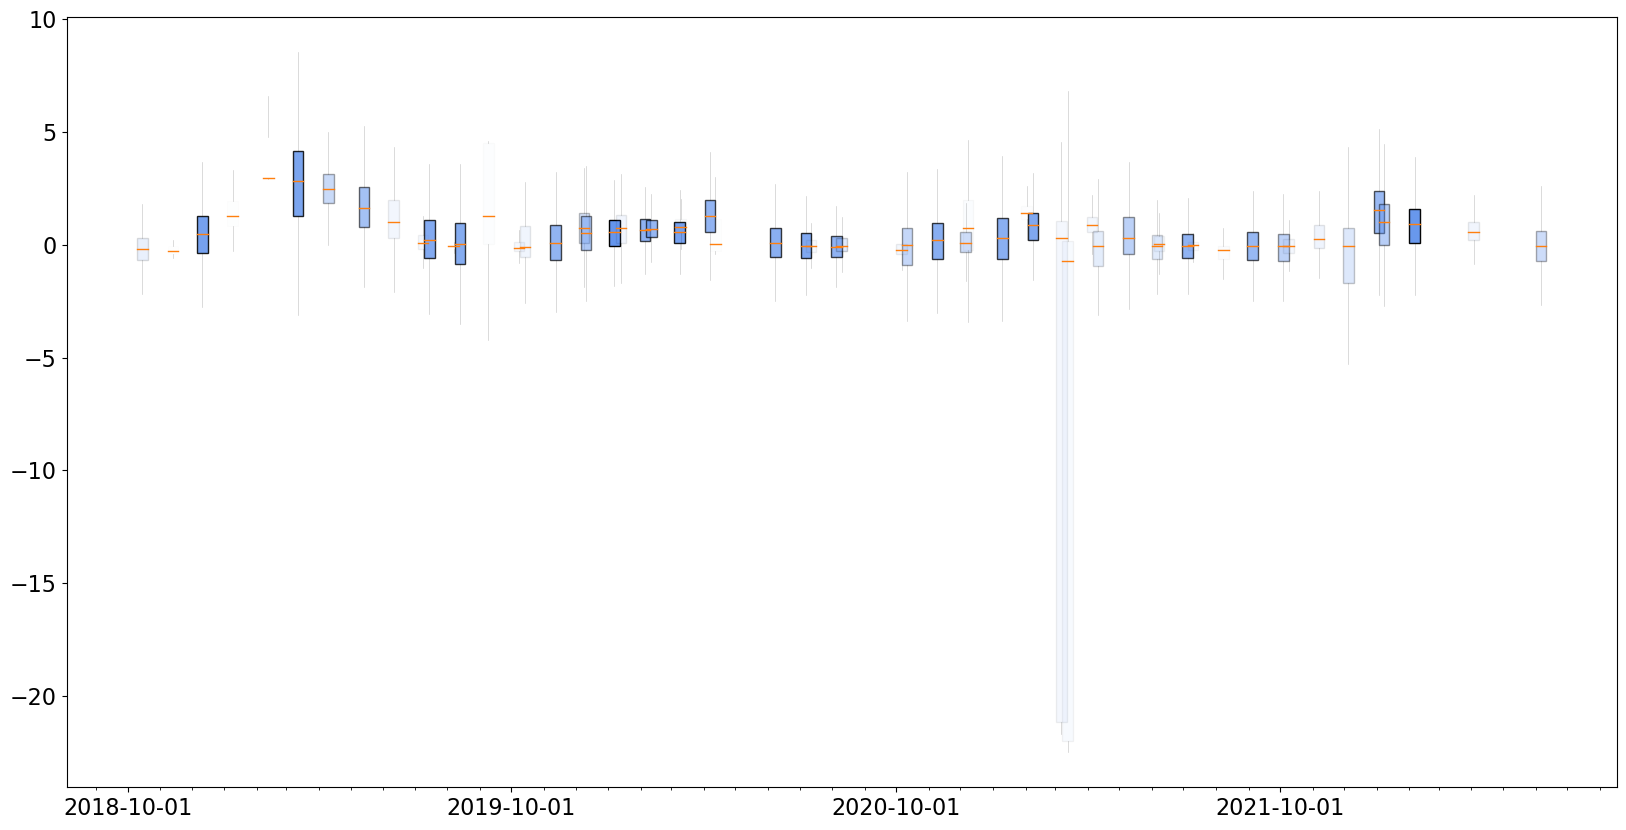

In [18]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'

f, ax = plt.subplots(figsize=(20,10))
bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, widths=10, patch_artist=True)

for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
    patch.set_alpha(alpha)
    patch.set_facecolor('cornflowerblue')

years = mdates.YearLocator(month=10)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
months = mdates.MonthLocator()
ax.xaxis.set_minor_locator(months)

### Transparent Boxplots with CDEC and ATL06SR Data

In [138]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=None, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 6)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats != None:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = rasterstats[2]/rasterstats[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':2},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':2}, widths=10, patch_artist=True)
    if rasterstats != None:
        bxp_f3 = ax.bxp(rasterstats[0], positions=rasterstats[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':0.5}, 
                        medianprops={'lw':2}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats != None:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_color('yellow')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend1.set_alpha(1)
    if rasterstats != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
        ax.add_artist(legend2)
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
        ax.add_artist(legend2)
    ax.add_artist(legend1)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)

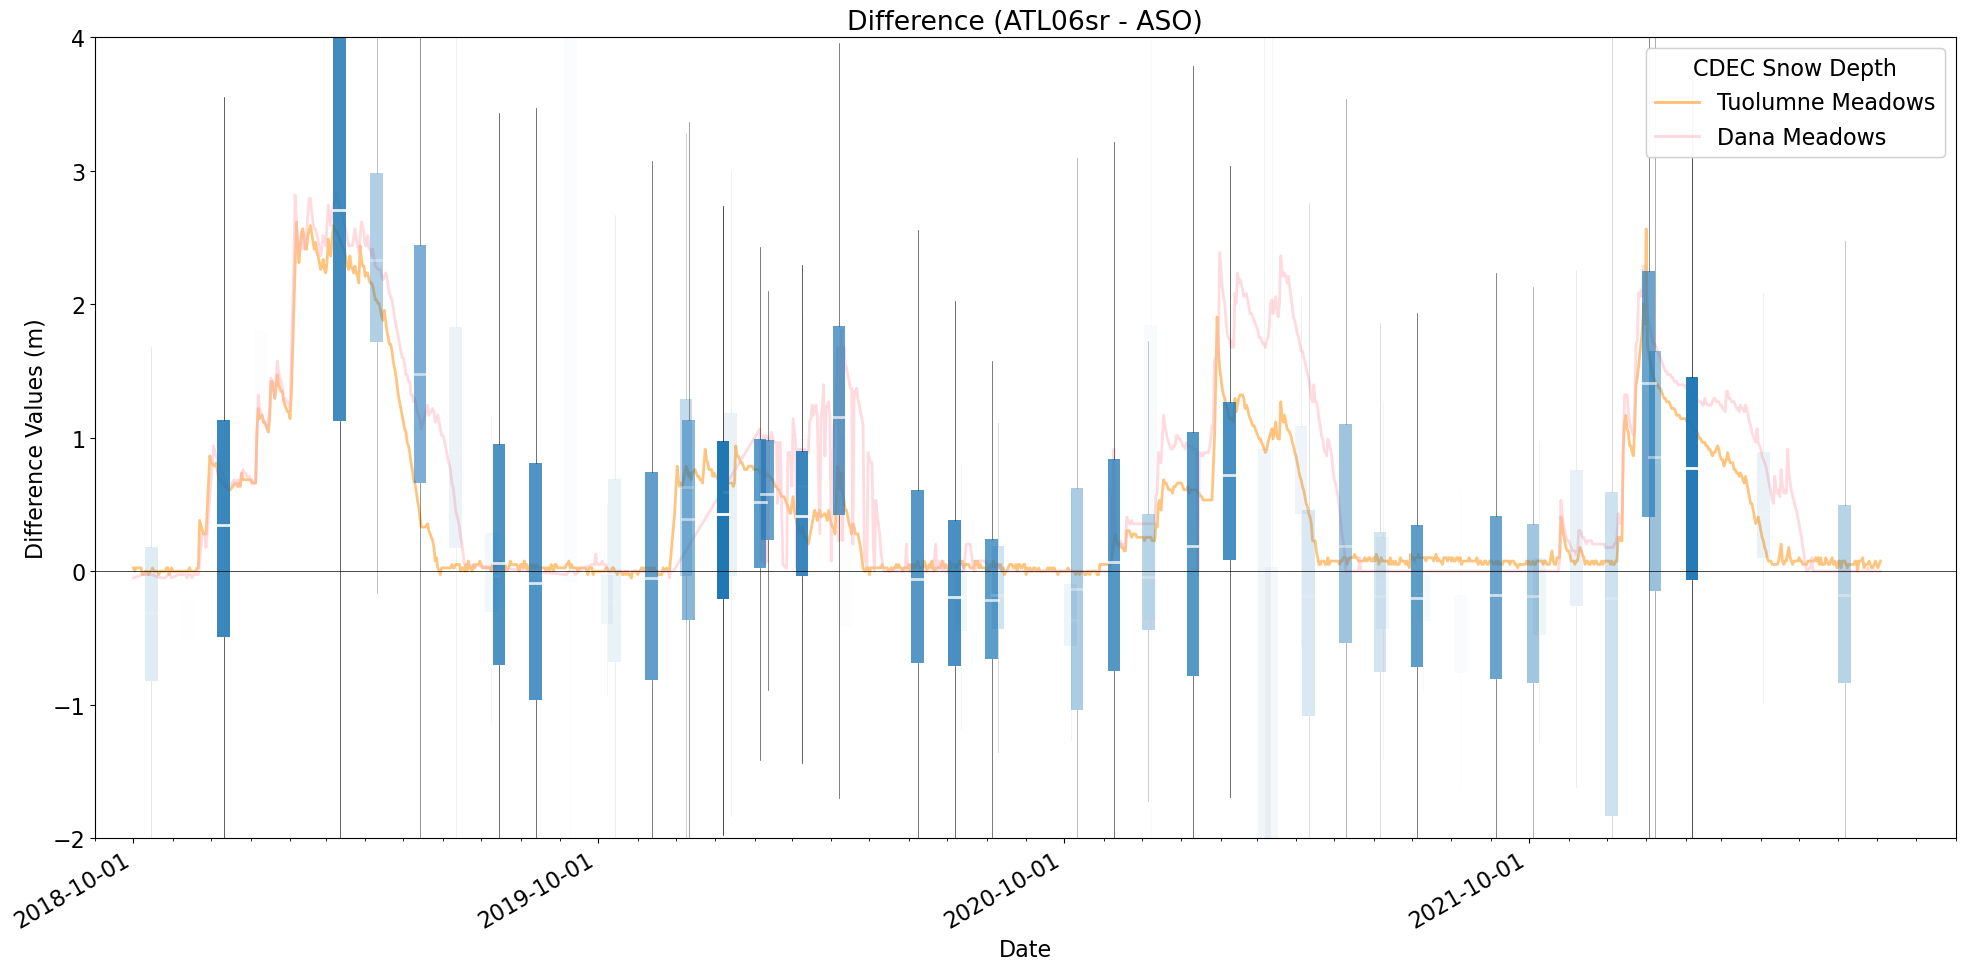

In [139]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,4), title='Difference (ATL06sr - ASO)', name = '../figures/boxplots_cdec.jpeg')

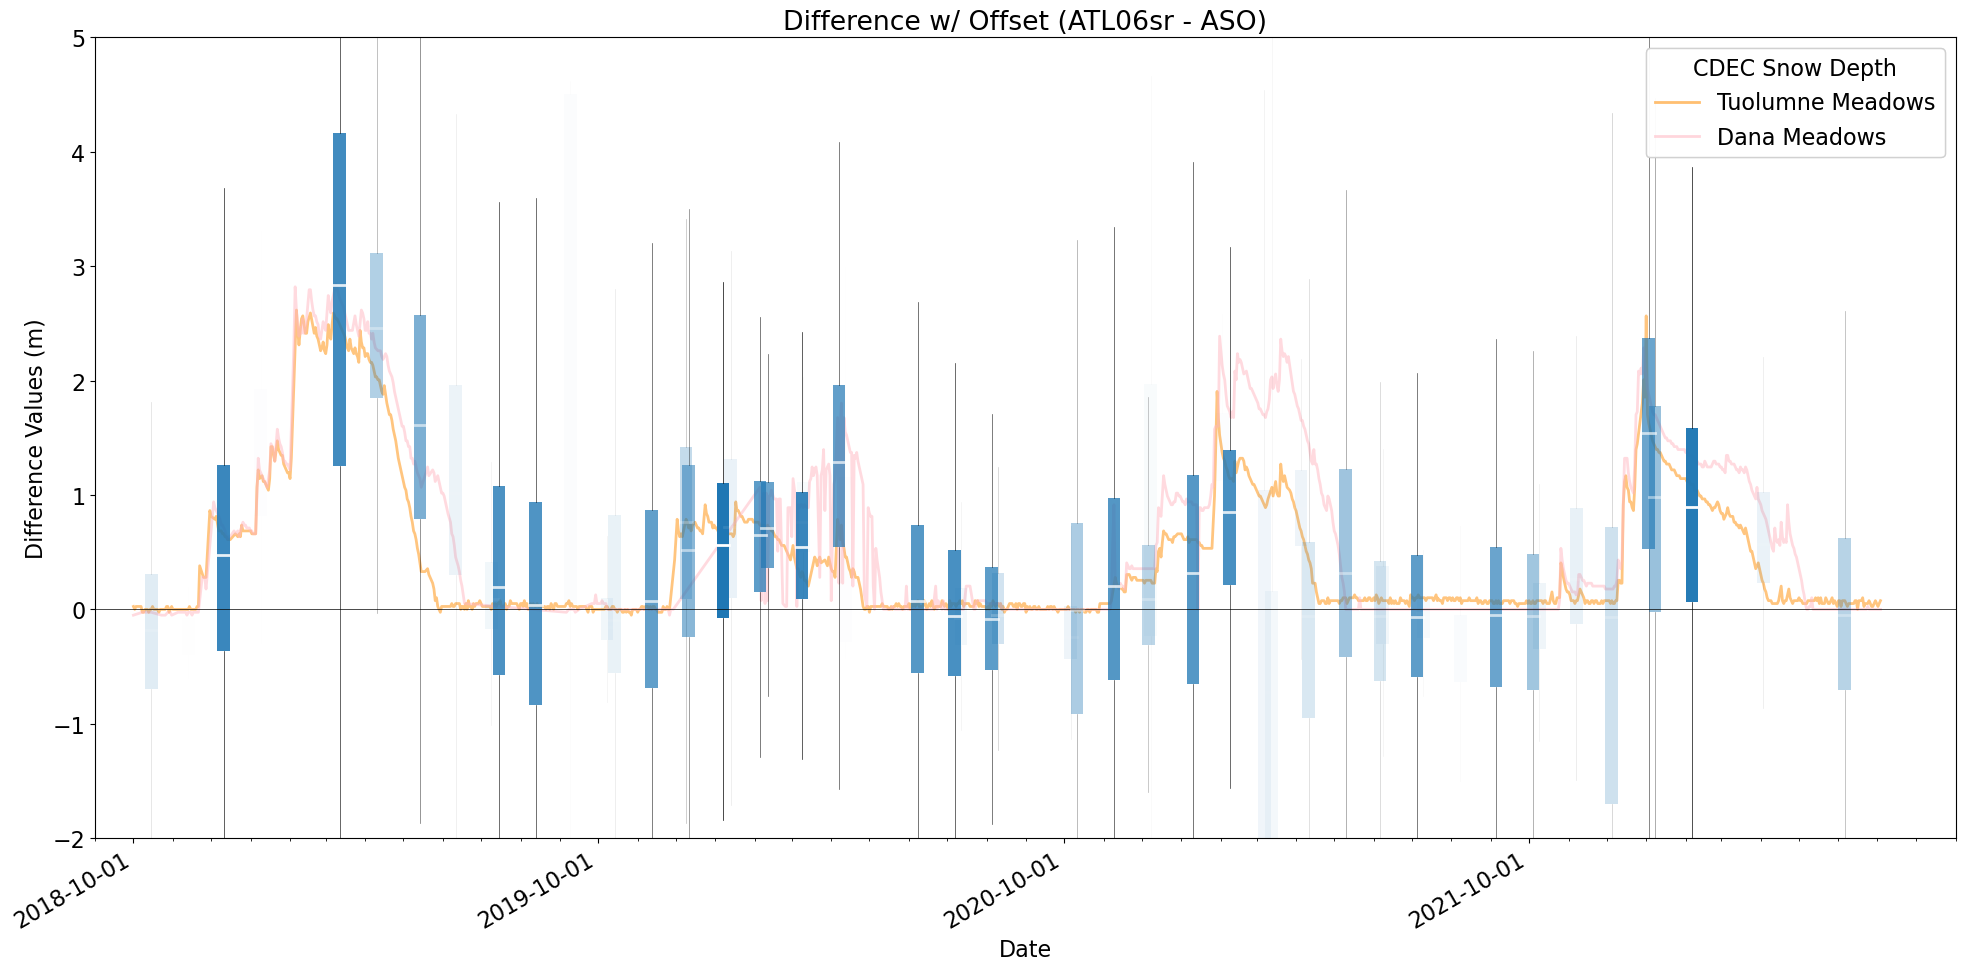

In [125]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', clim=(-2,5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = '../figures/boxplots_cdec.jpeg')

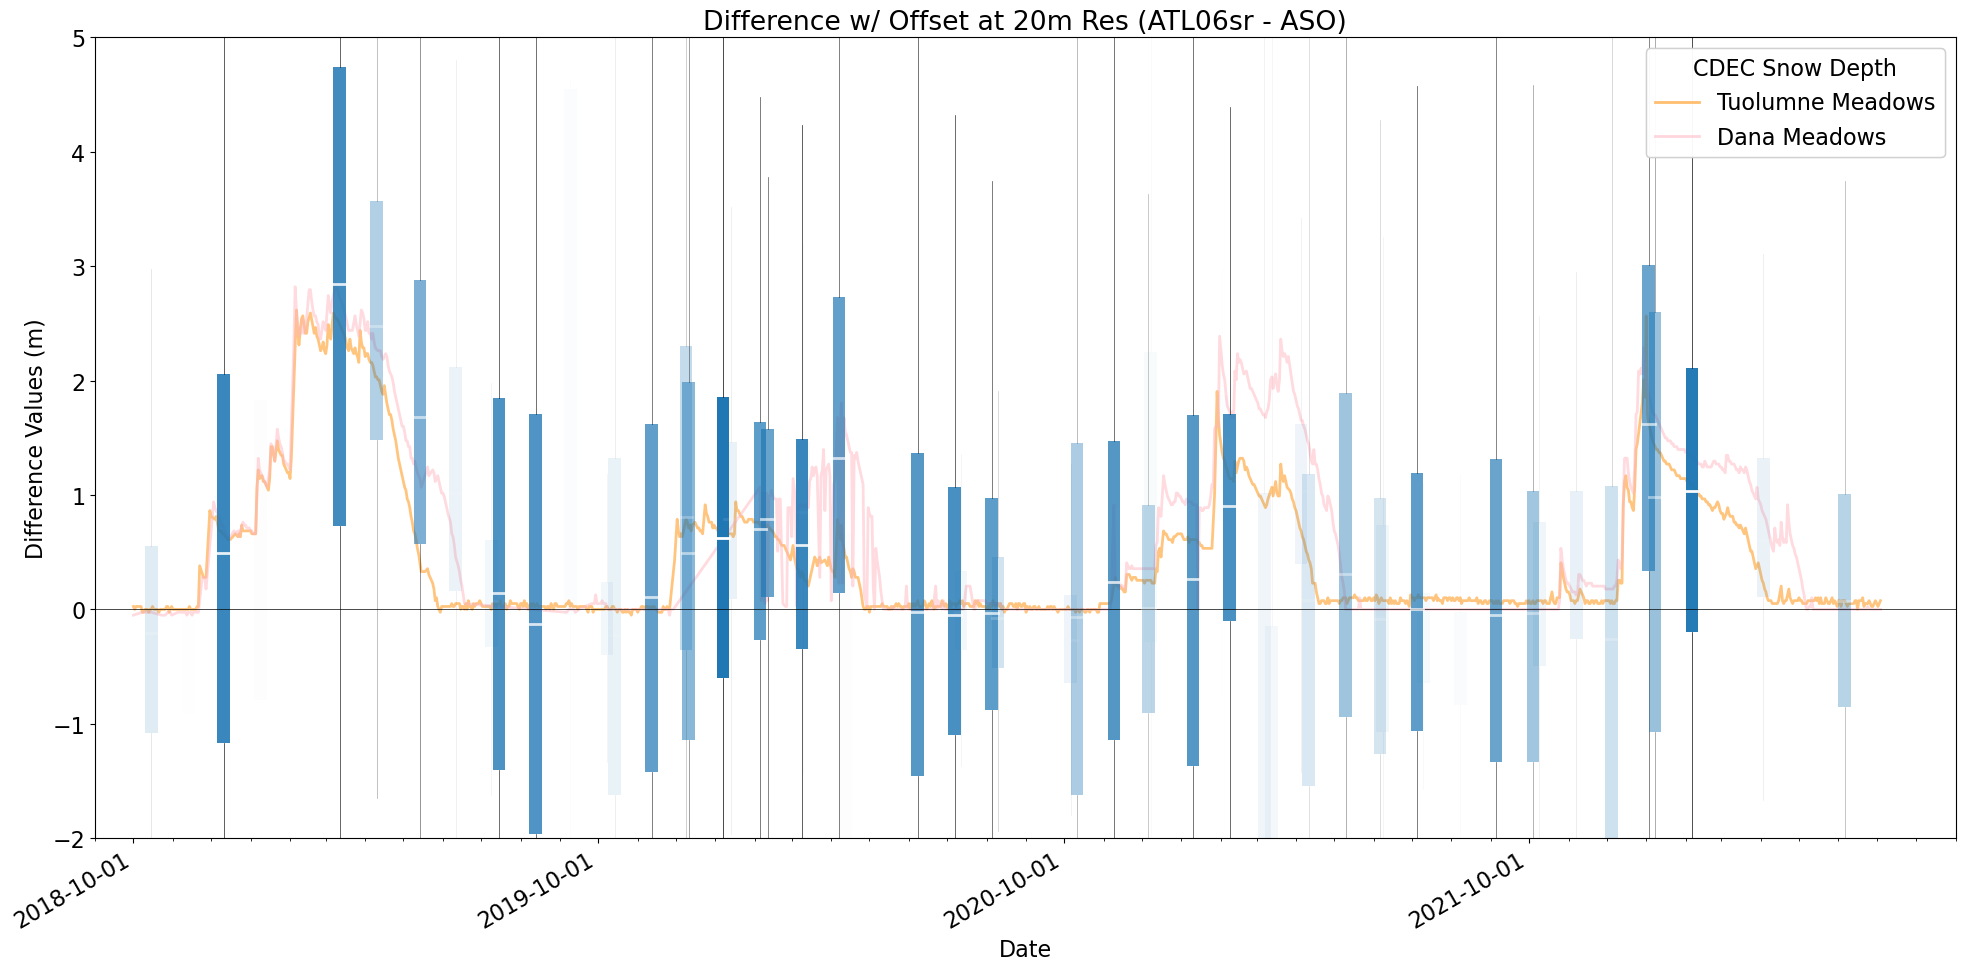

In [126]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-2,5), title = 'Difference w/ Offset at 20m Res (ATL06sr - ASO)', name = '../figures/boxplots_cdec_diffplus_20m.jpeg')

### Transparent boxplots with ASO Snow-On Data

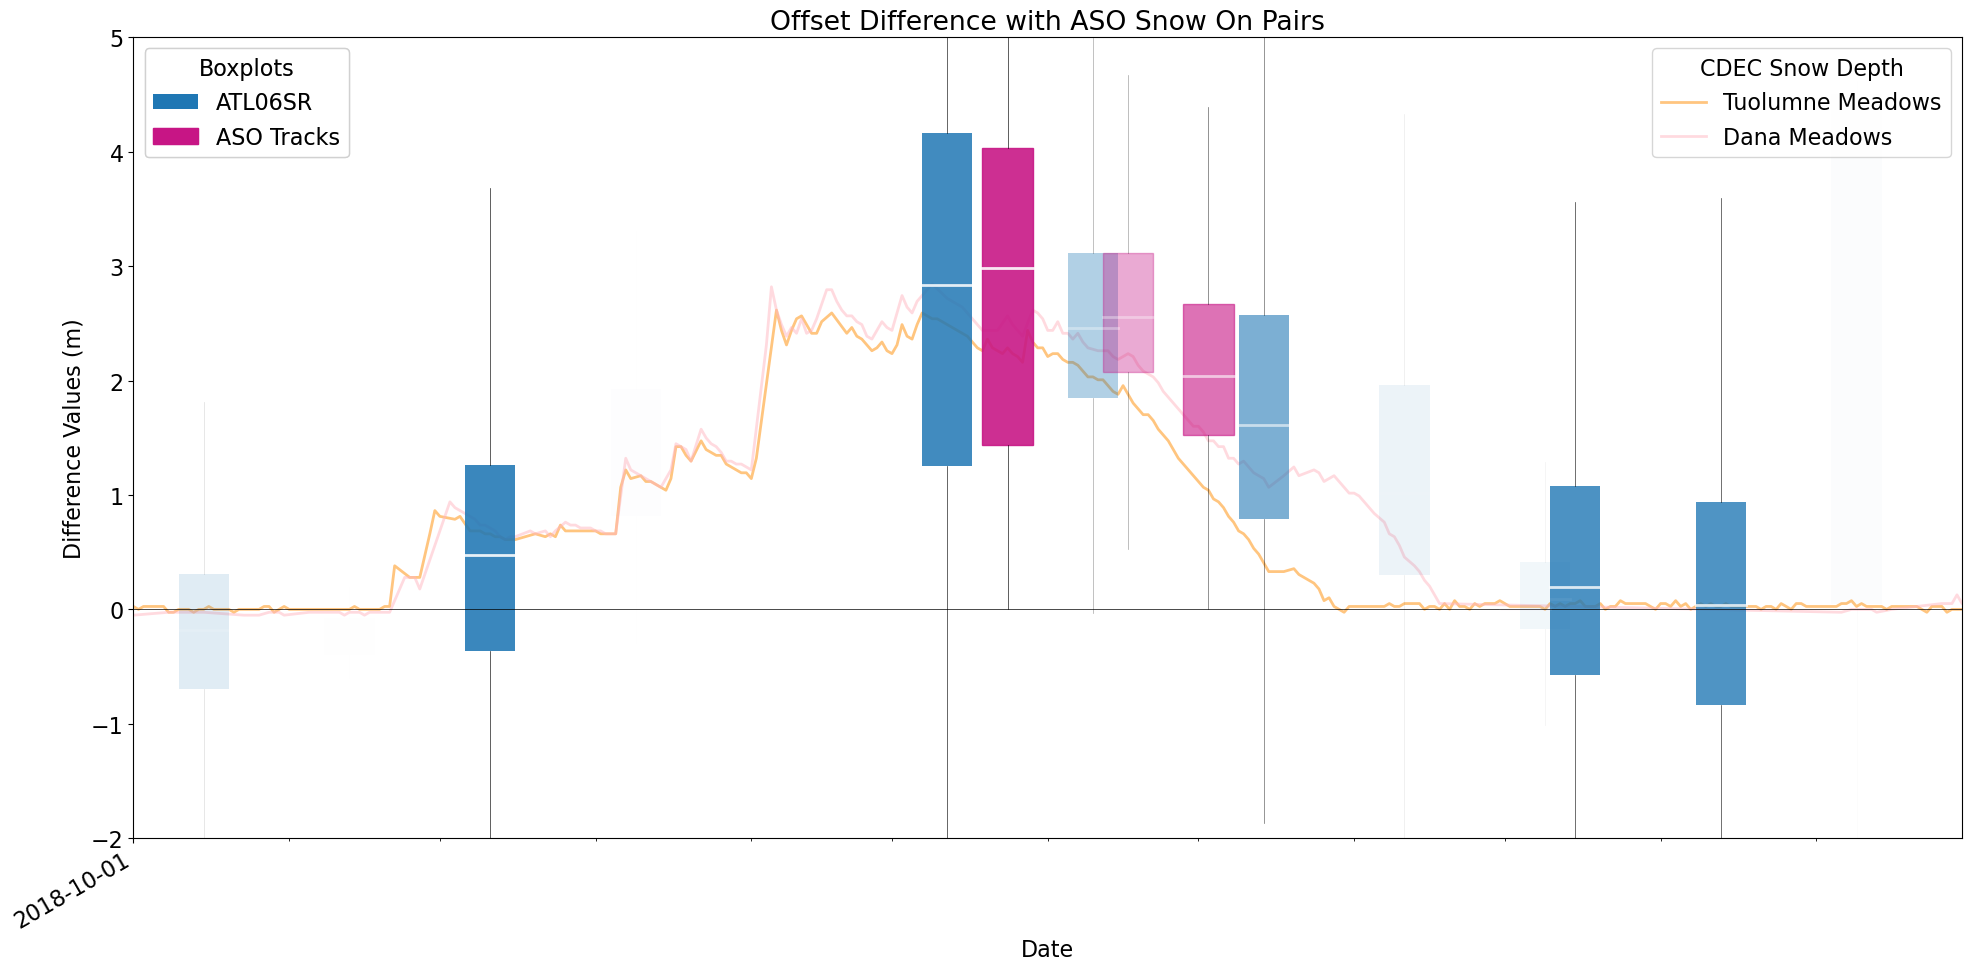

In [129]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Offset Difference with ASO Snow On Pairs', name = '../figures/boxplots_cdec_aso.jpeg')

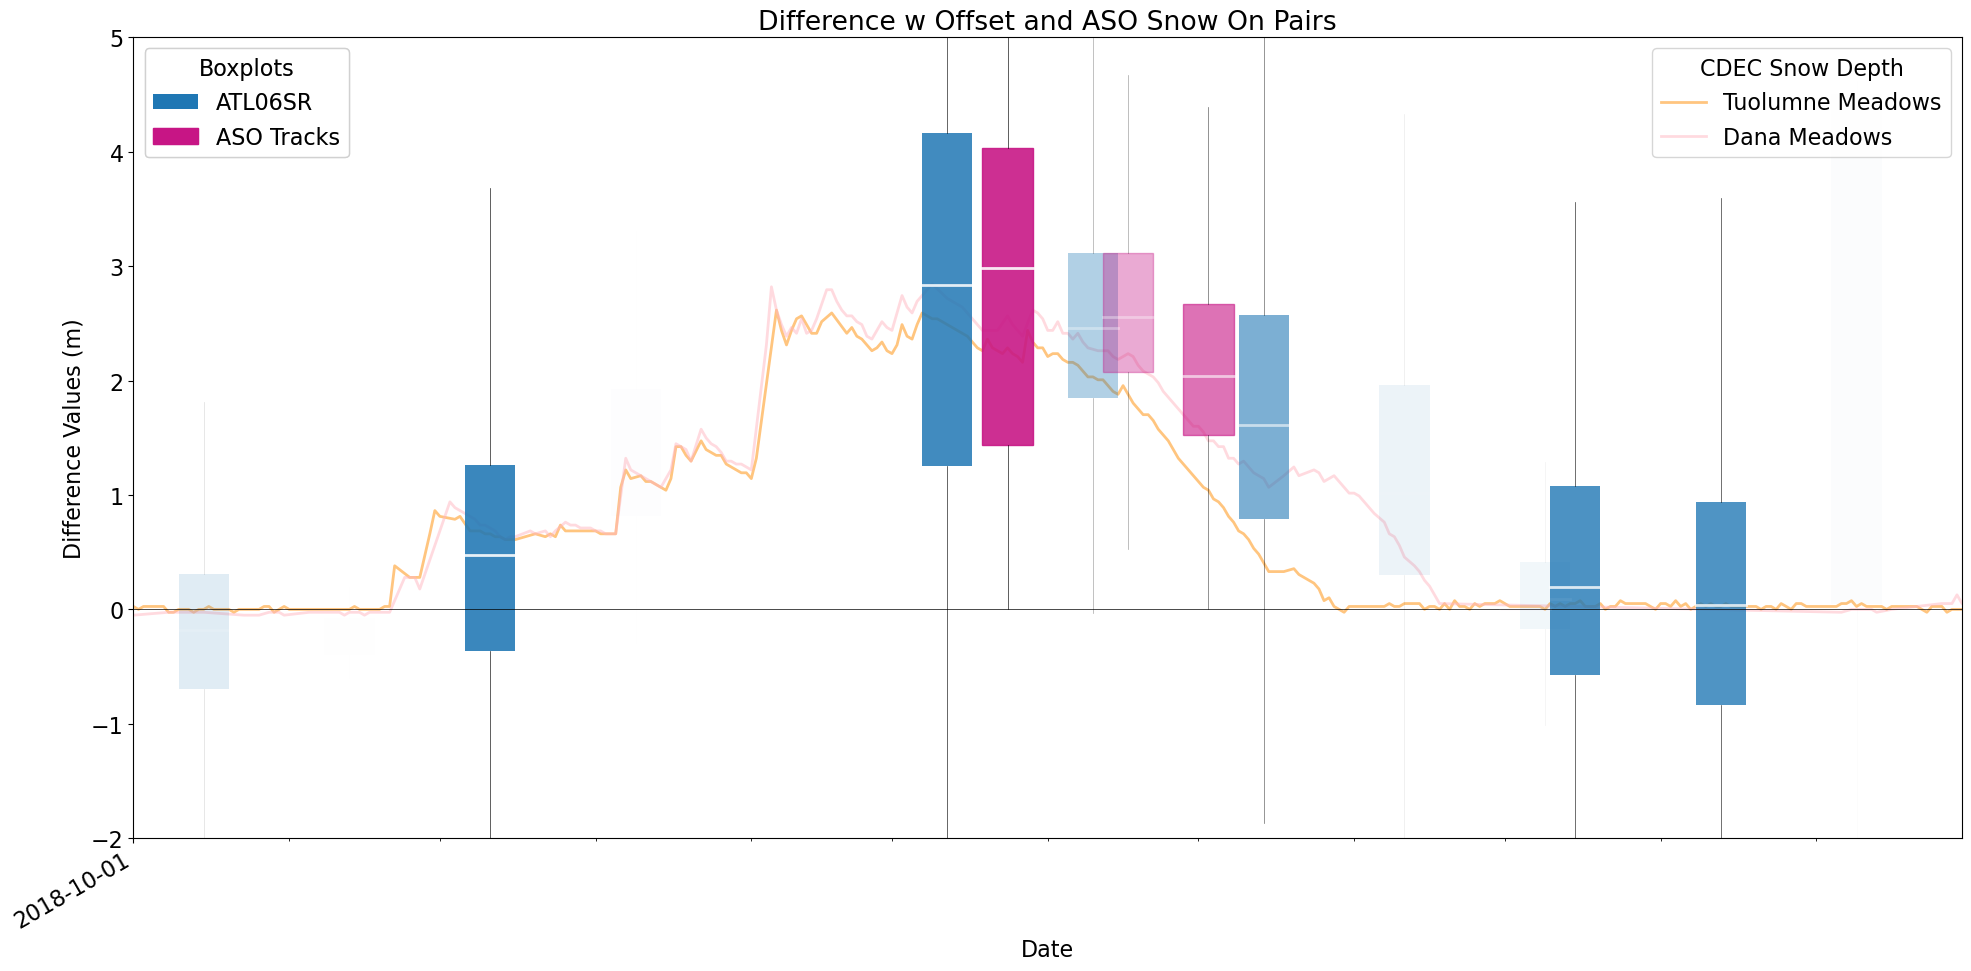

In [131]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Difference w Offset and ASO Snow On Pairs', name = '../figures/boxplots_cdec_aso.jpeg')

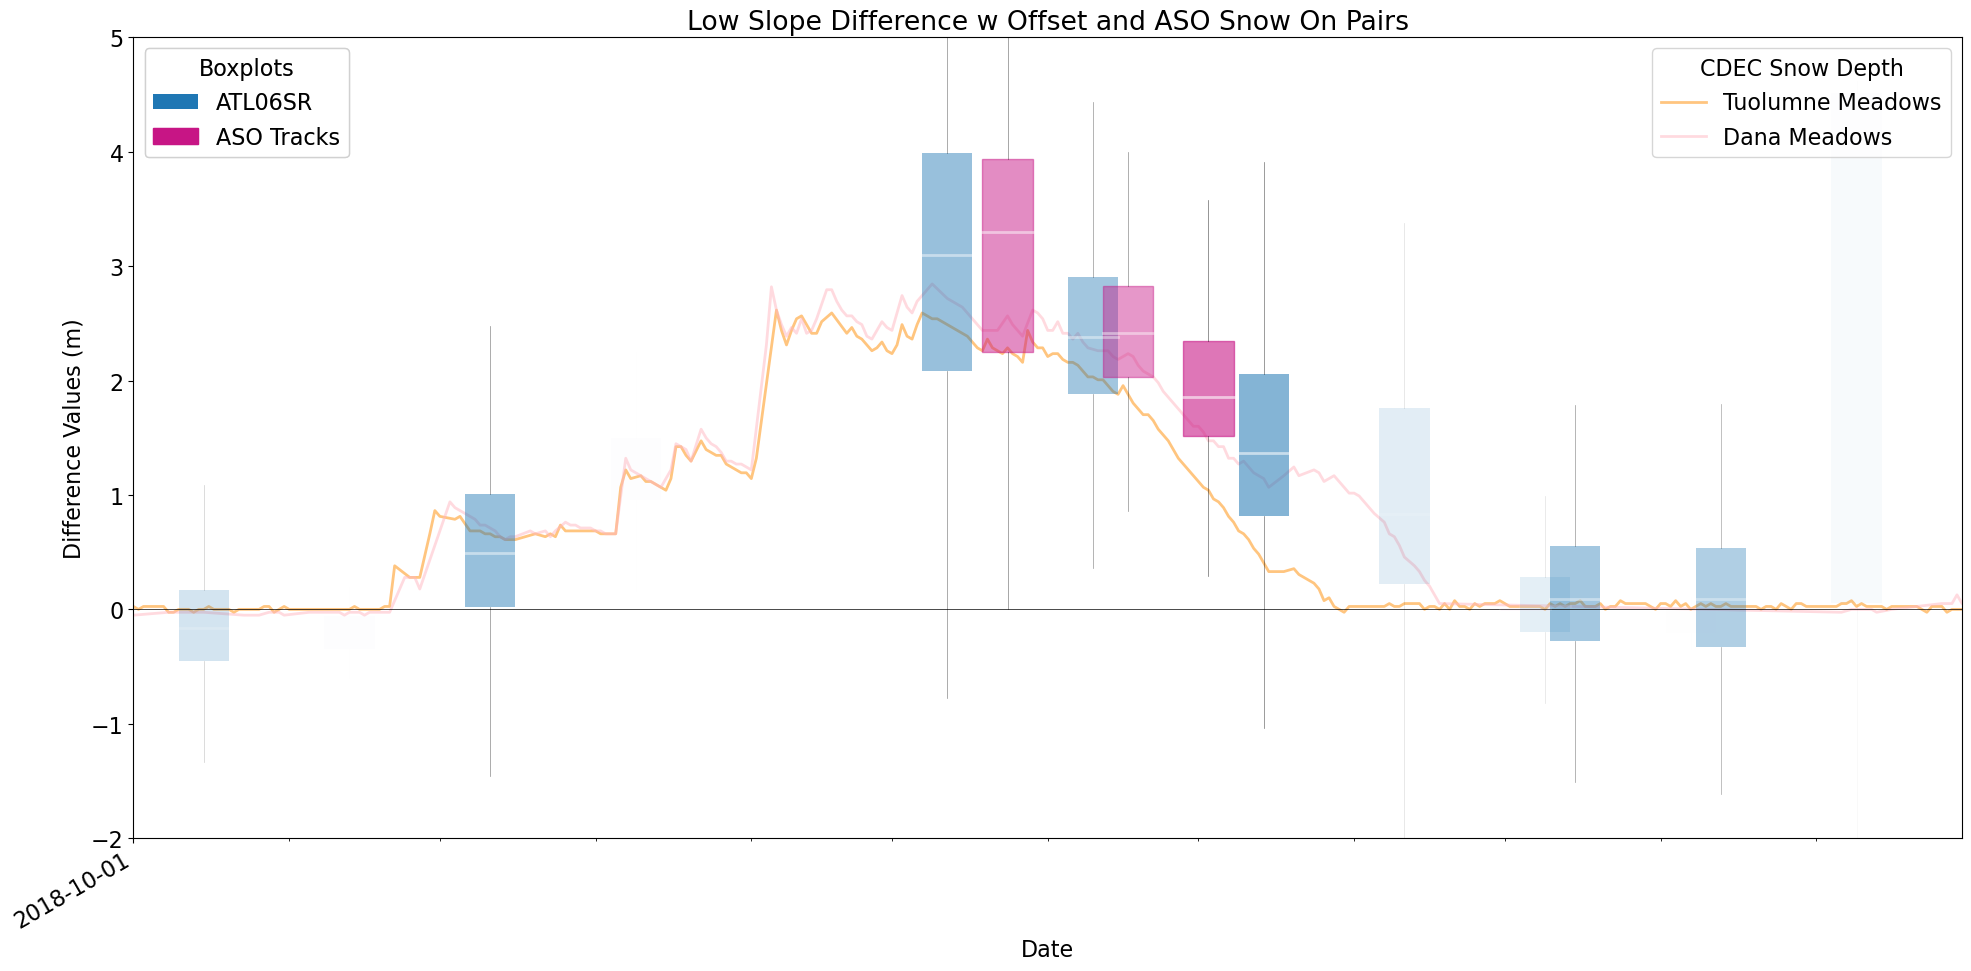

In [132]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = '../figures/boxplots_cdec_aso.jpeg')

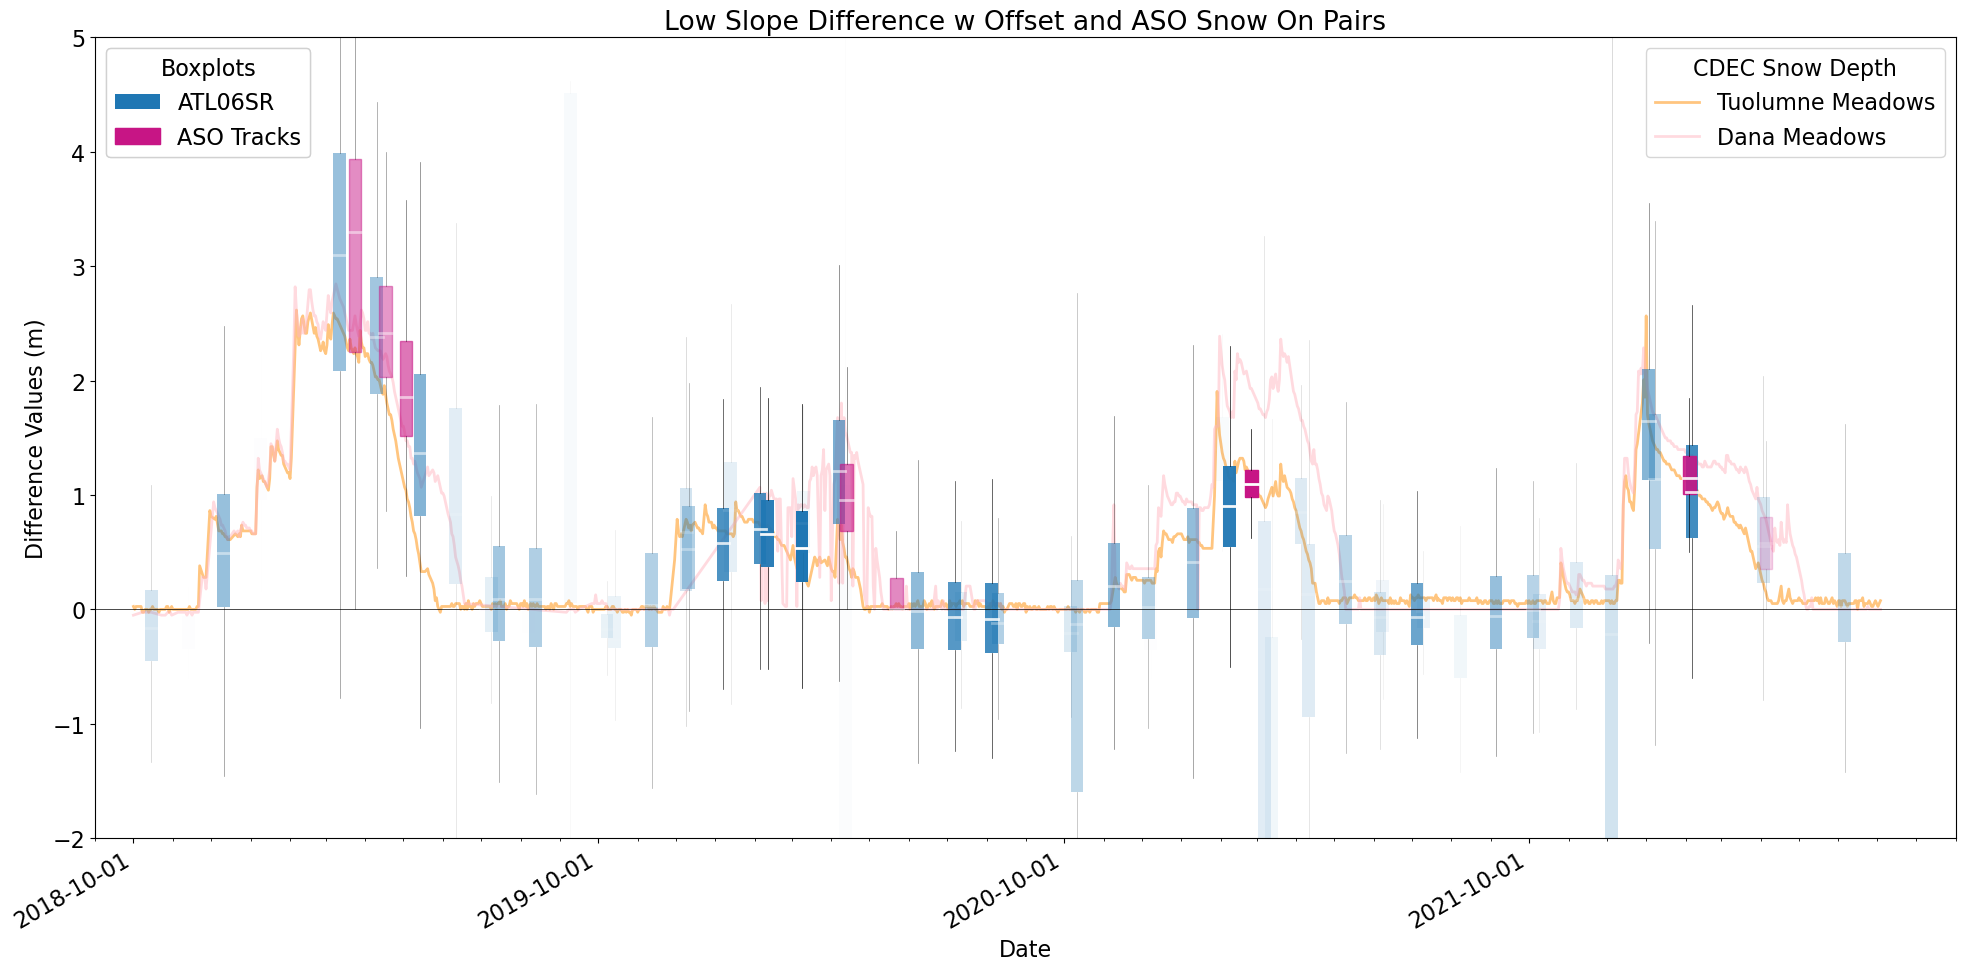

In [133]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = '../figures/boxplots_cdec_aso.jpeg')

## Transparent Boxplots with ASO Snow-On at ATL06SR and Entire Basin

#### Use rasterstats to make boxplots of ASO data for the Study area

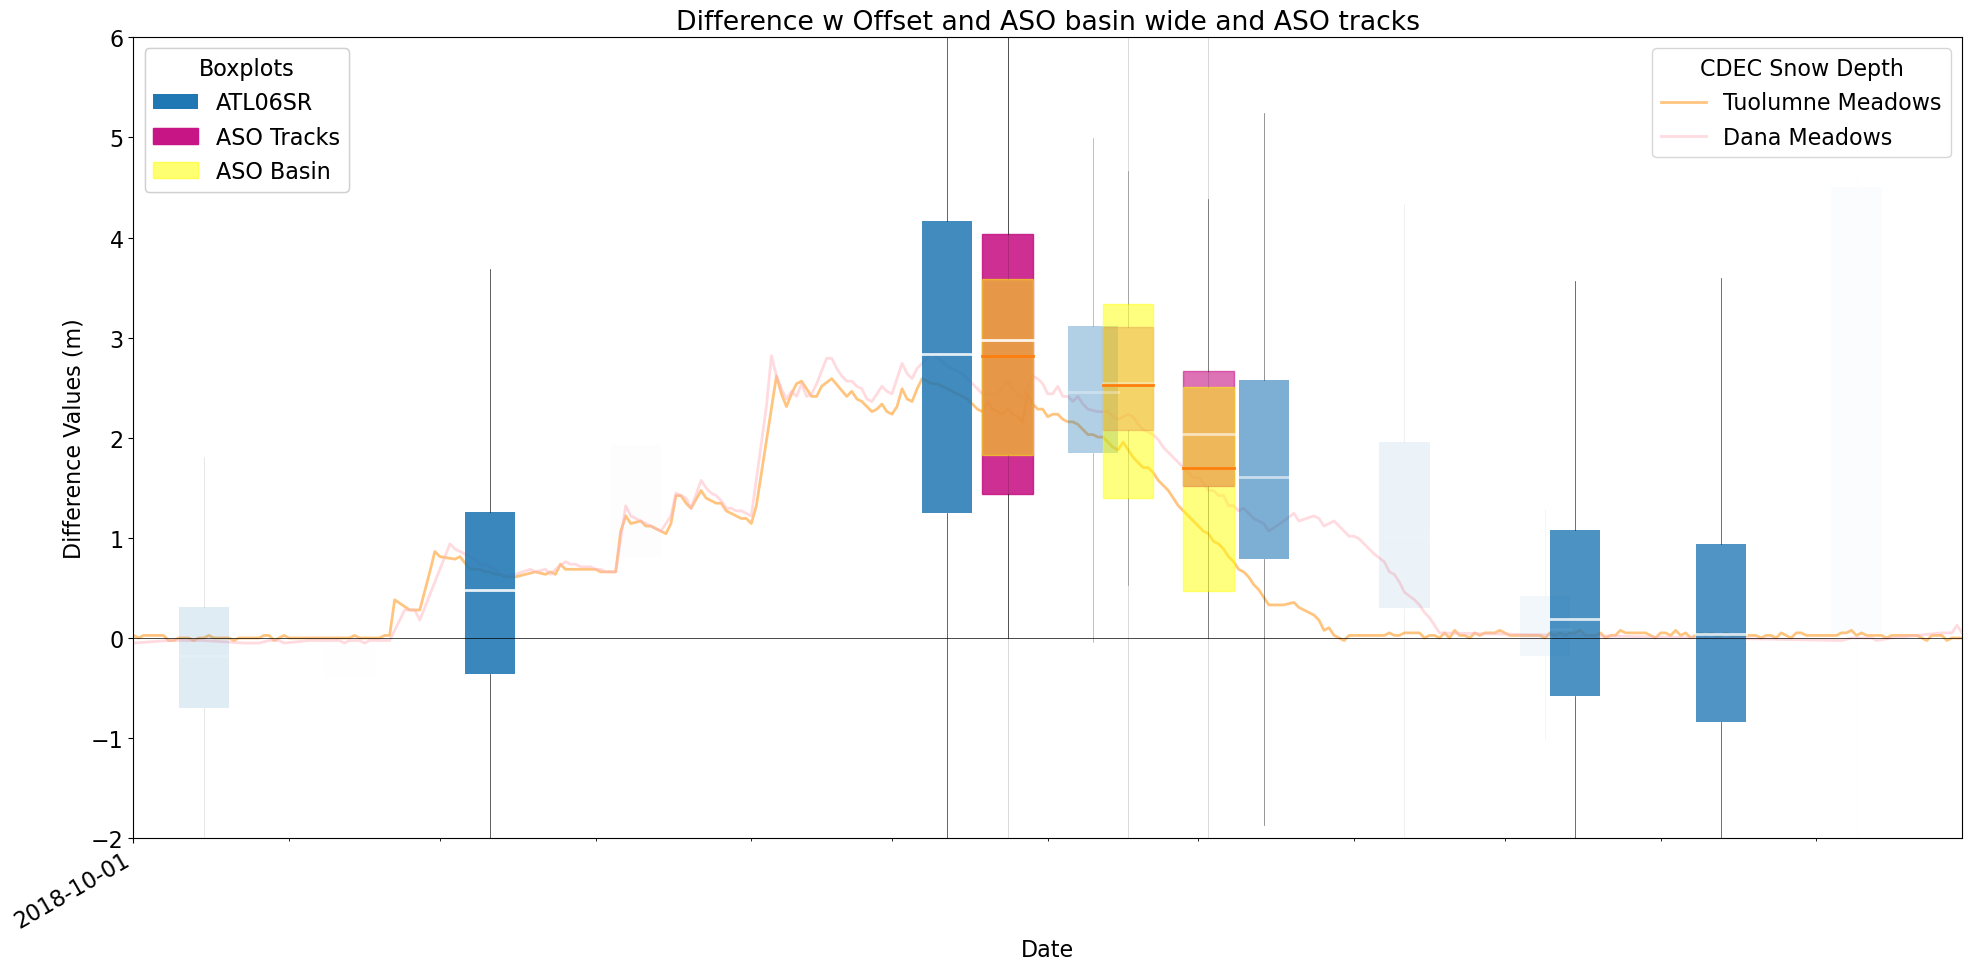

In [134]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-2,6), name = '../figures/boxplots_cdec_aso.jpeg')

### Look at all years of data:

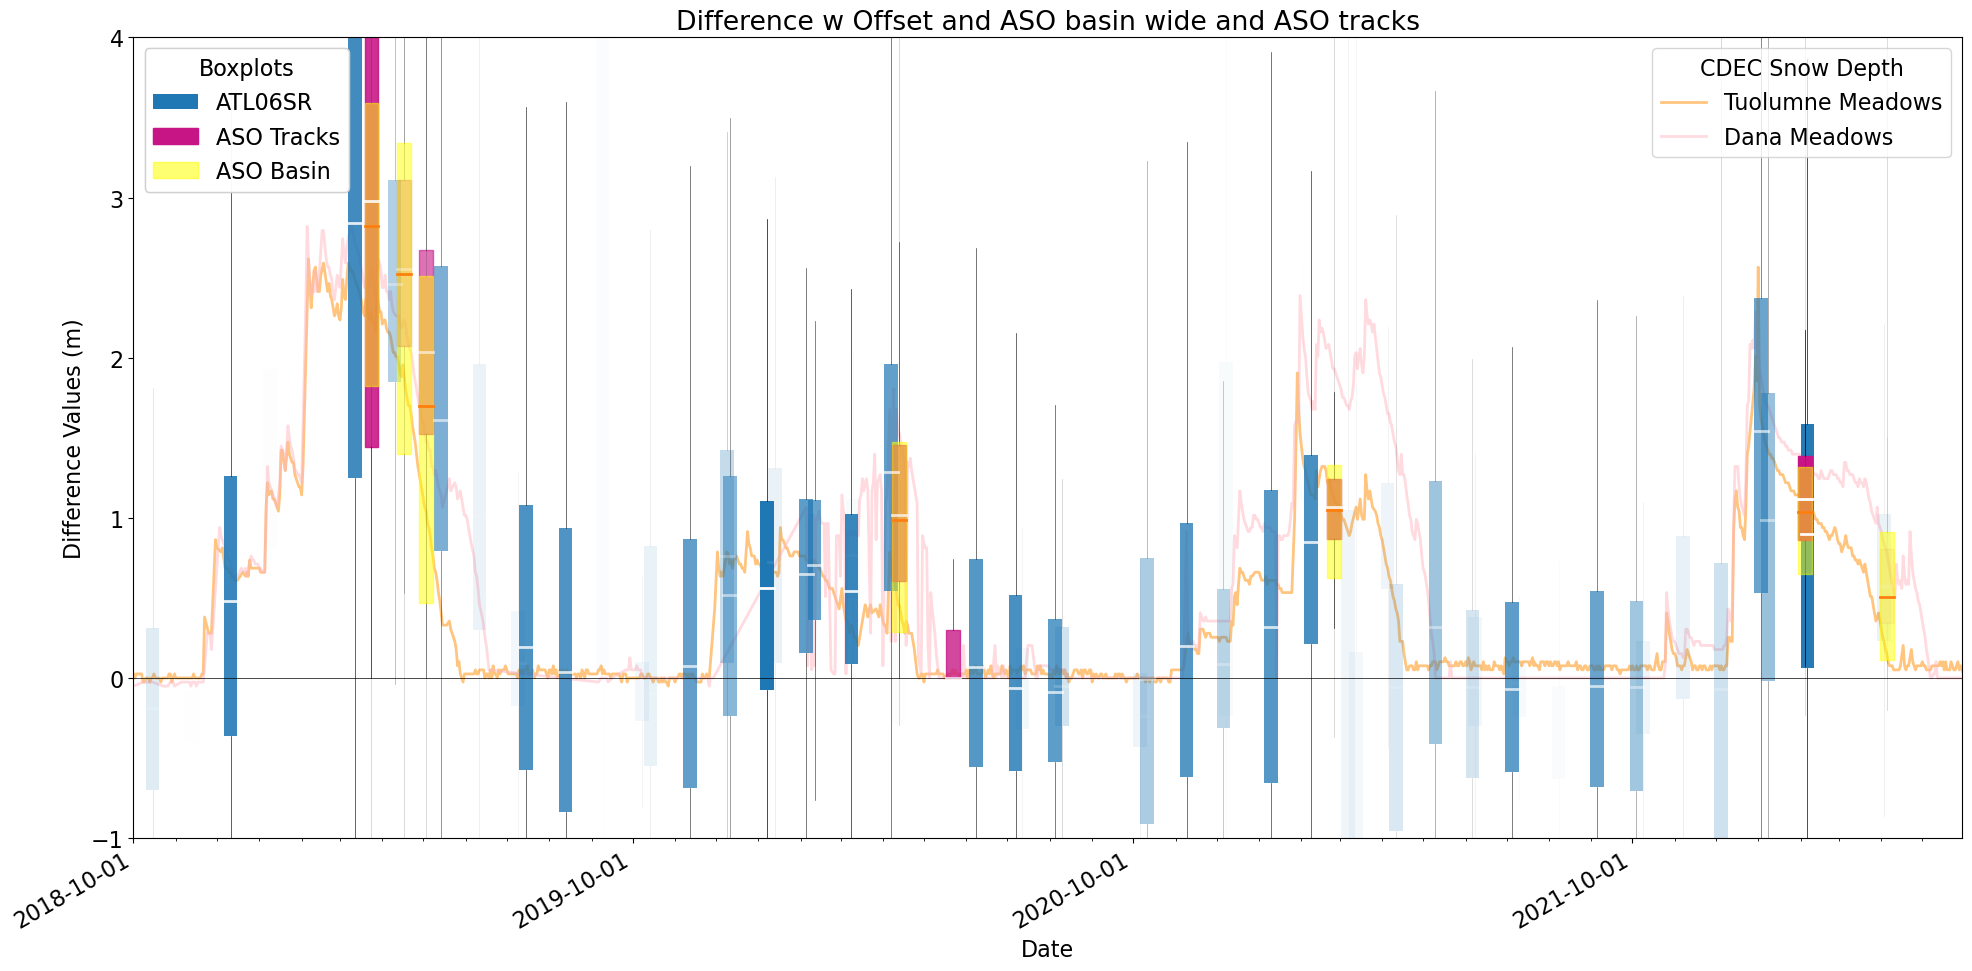

In [135]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-1,4), name = '../figures/boxplots_cdec_aso_allyears.jpeg')

## Look at only ATL06SR and ASO Temporal Pairs

In [136]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2019, 7, 9),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

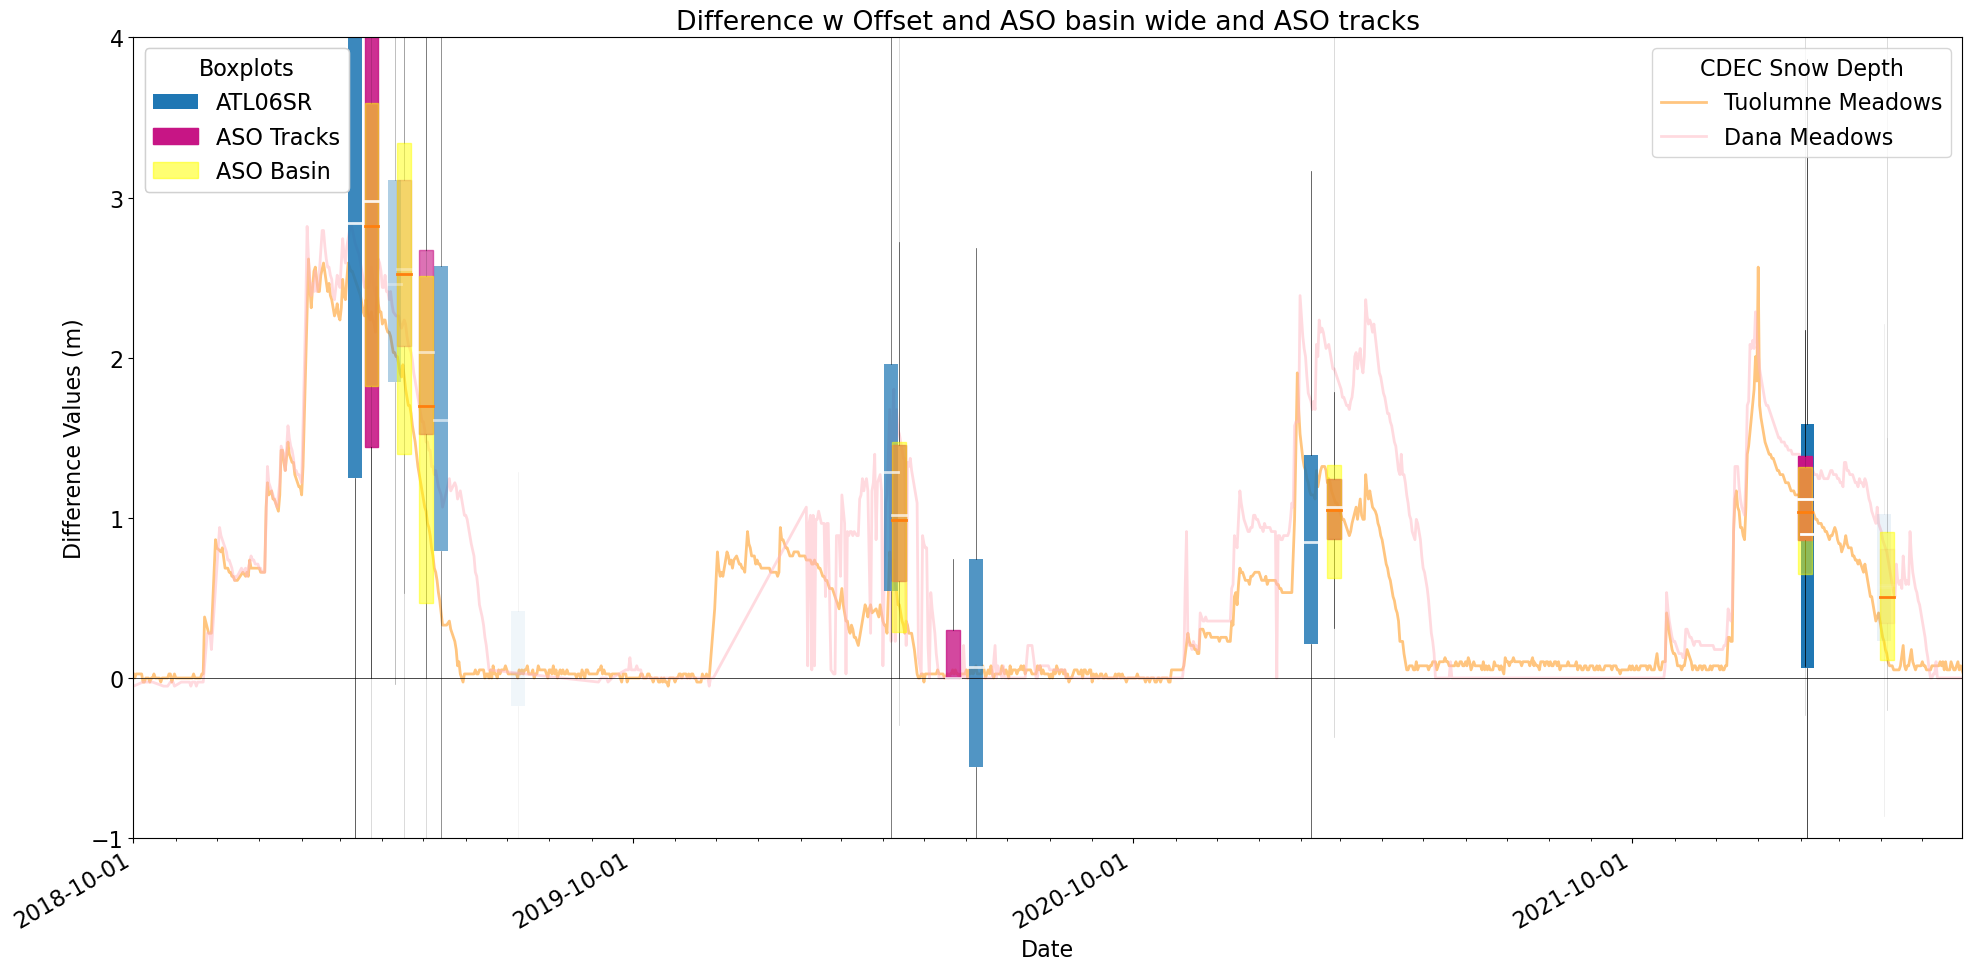

In [137]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-1,4), name = '../figures/boxplots_cdec_aso_allyears.jpeg')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

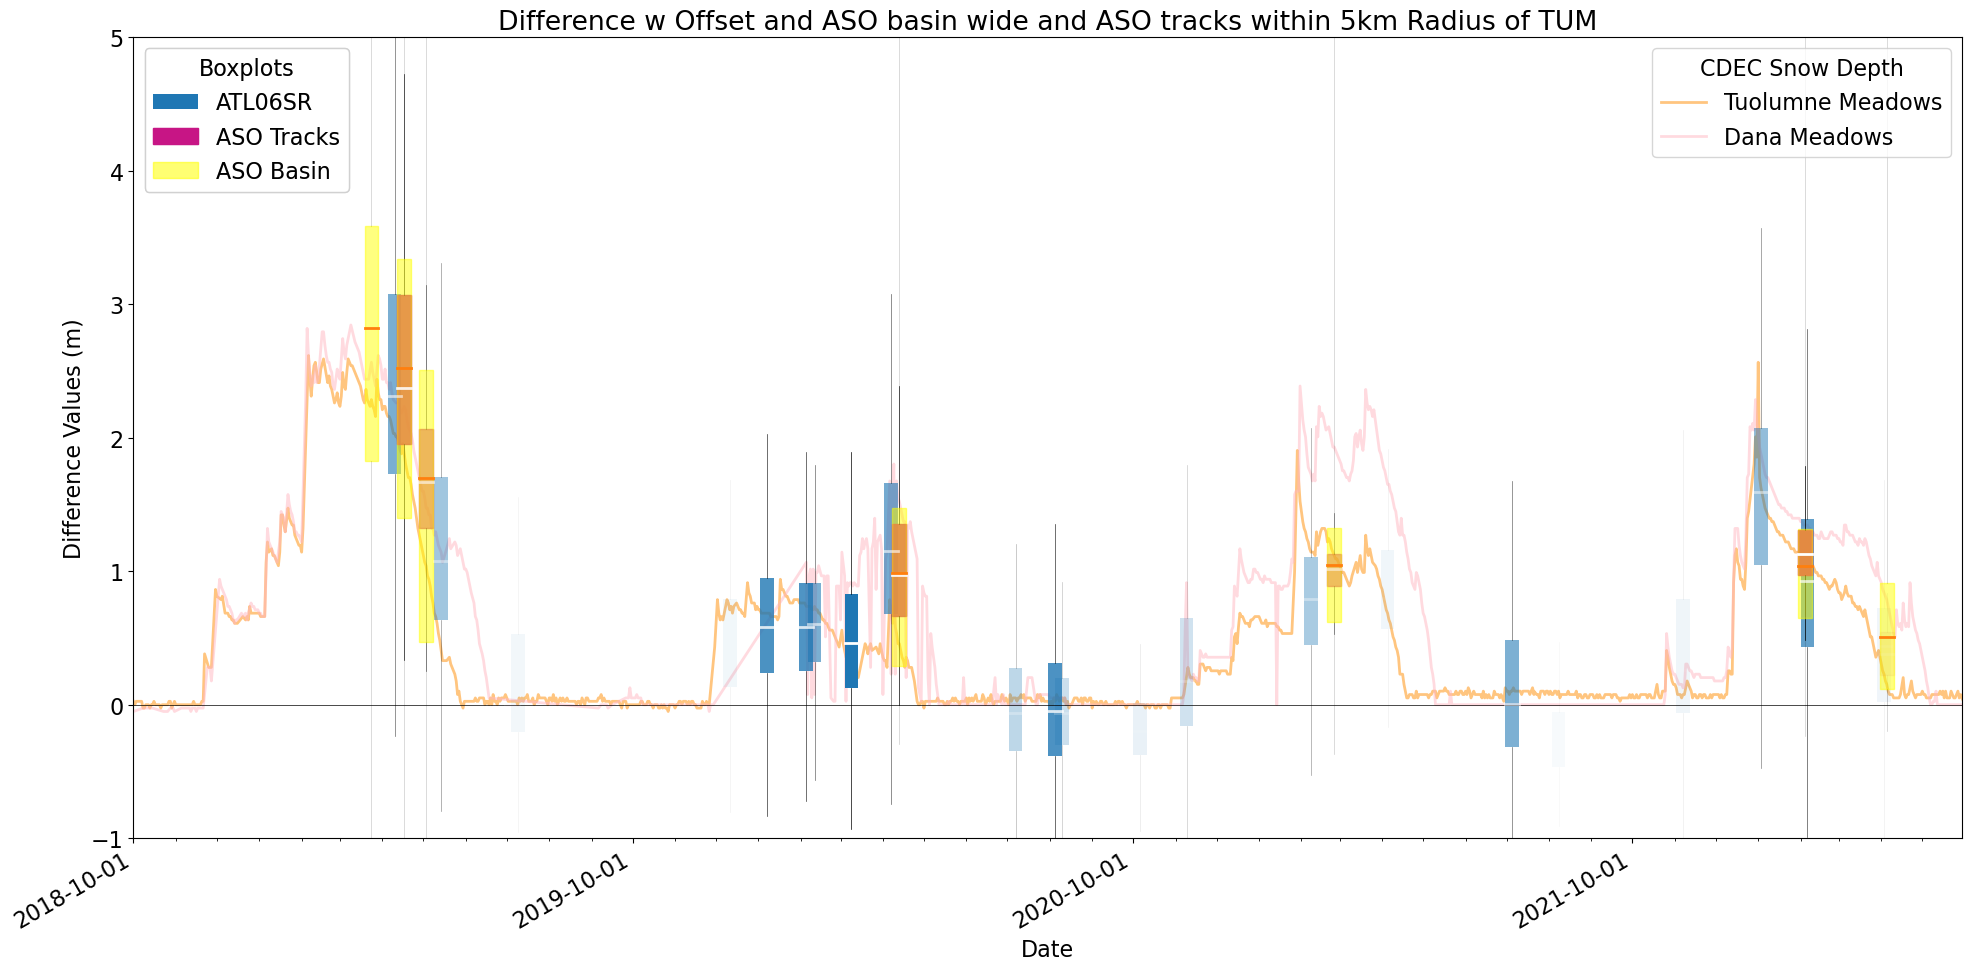

In [140]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[2, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = '../figures/boxplots_cdec_aso_allyears.jpeg')

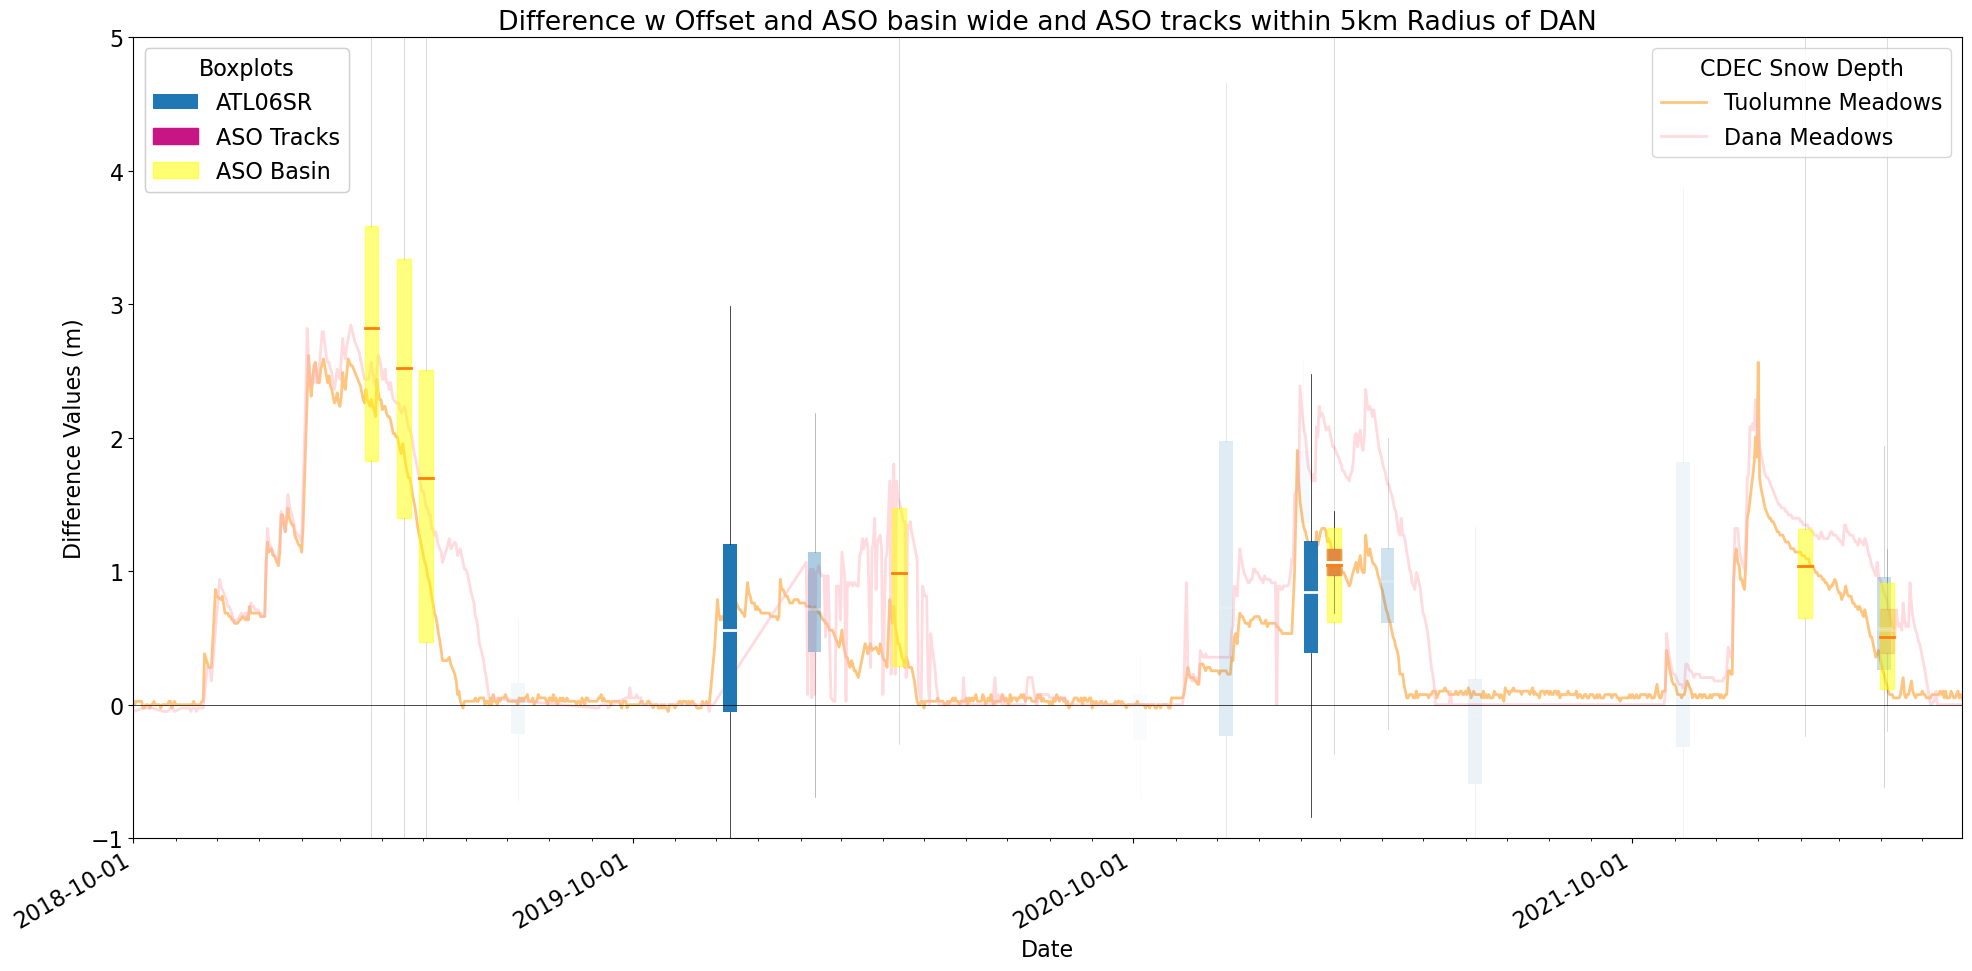

In [141]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = '../figures/boxplots_cdec_aso_allyears.jpeg')

## Old, less universal plotting functions:

In [19]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [80]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)